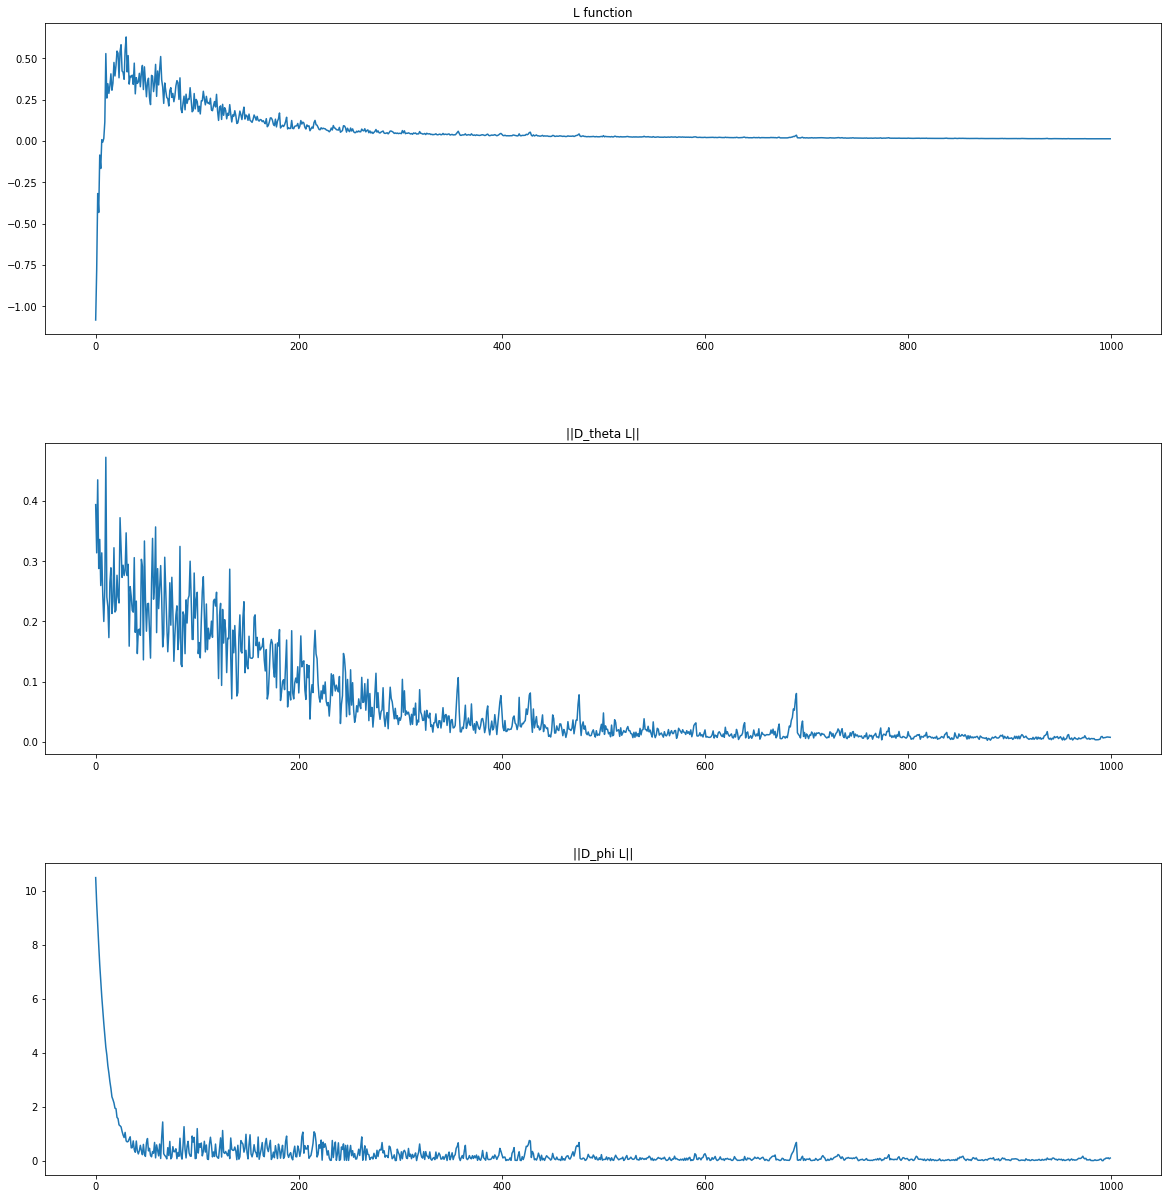

In [3]:
import numpy as np
from matplotlib import pyplot as plt

N, p = 30, 20
np.random.seed(0)
X = np.random.randn(N,p)
Y = 2*np.random.randint(2, size = N) - 1
lamda = 30

theta = 0.1 * np.random.randn(p)
phi = 0.1 * np.random.randn(p)
alpha = 3e-1
beta = 1e-4

epoch = 1000
L_val = []
d_phi_val = []
d_theta_val = []

for _ in range(epoch):
    for __ in range(N):
        k = np.random.randint(N, size=1)
        d_phi_k = Y[k] / (1 + np.exp(Y[k] * ((X[k,:]-phi.reshape(1,-1)) @ theta))) * theta - lamda * phi
        d_theta_k = (-Y[k] / (1 + np.exp(Y[k] * ((X[k,:]-phi.reshape(1,-1)) @ theta)))).reshape(-1,1)*(X[k,:]-phi.reshape(1,-1))
        theta -= alpha * d_theta_k.squeeze()
        phi += beta * d_phi_k.squeeze()
    L_i = np.average(np.log(1 + np.exp(-Y * ((X - phi.reshape(1,-1)) @ theta)))) - lamda/2 * np.linalg.norm(phi, axis=0, ord=2) **2
    d_phi = np.average(Y / (1 + np.exp(Y * ((X-phi.reshape(1,-1)) @ theta)))) * theta - lamda * phi
    d_theta = np.average(( -Y / (1 + np.exp(Y * ((X-phi.reshape(1,-1)) @ theta))) ).reshape(-1,1)*(X-phi.reshape(1,-1)), axis=0)
    L_val.append(L_i)
    d_phi_val.append(d_phi)
    d_theta_val.append(d_theta)

fig, ax = plt.subplots(figsize=(20, 20))
plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.35)
plt.subplot(3, 1, 1)
plt.title("L function")
plt.plot(L_val)
plt.subplot(3, 1, 2)
plt.title("||D_theta L||")
plt.plot(np.linalg.norm(d_theta_val, axis=1, ord=2))
plt.subplot(3, 1, 3)
plt.title("||D_phi L||")
plt.plot(np.linalg.norm(d_phi_val, axis=1, ord=2))
plt.show()


In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

"""
Step 0 : Define training configurations
"""

batch_size = 128
learning_rate = 5e-4
num_epochs = 2000
reg_coeff = 500
device = "cuda:0" if torch.cuda.is_available() else "cpu"


In [100]:
"""
Step 1 : Define custom dataset 
"""

def make_swiss_roll(n_samples=2000, noise = 1.0, dimension = 2, a = 20, b = 5):
    """
    Generate 2D swiss roll dataset 
    """
    t = 2 * np.pi * np.sqrt(np.random.uniform(0.25,4,n_samples))
    
    X = 0.1 * t * np.cos(t)
    Y = 0.1 * t * np.sin(t)
    
    errors = 0.025 * np.random.multivariate_normal(np.zeros(2), np.eye(dimension), size = n_samples)
    X += errors[:, 0]
    Y += errors[:, 1]
    return np.stack((X, Y)).T

In [101]:
def show_data(data, title):
    """
    Plot the data distribution
    """
    sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
    plt.figure(figsize = (5, 5))
    plt.rc('text', usetex = False)
    plt.rc('font', family = 'serif')
    plt.rc('font', size = 10)
    
    g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")
    
    g.grid(False)
    plt.margins(0, 0)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.title(title)
    plt.show()

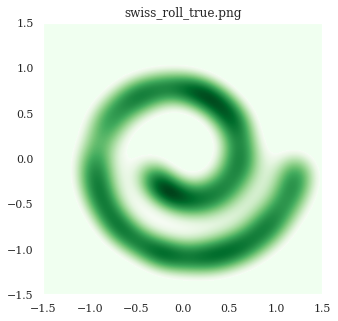

size of data (2000, 2)


In [102]:
"""
Step 2 : Define custom dataset and dataloader. 
"""

class SwissRollDataset(Dataset) : 
    def __init__(self, data) : 
        super().__init__()
        self.data = torch.from_numpy(data)
    
    def __len__(self) : 
        return len(self.data)
    
    def __getitem__(self, idx) :
        return self.data[idx]

    
data = make_swiss_roll()
dataset = SwissRollDataset(data)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
show_data(data, 'swiss_roll_true.png')

print("size of data", data.shape)

In [110]:
"""
Step 3 : Implement models
"""

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.linear_stack = nn.Sequential(nn.Linear(2, 128), 
                                          nn.LeakyReLU(negative_slope=0.1), 
                                          nn.Linear(128, 128), 
                                          nn.Tanh(),
                                          nn.Linear(128, 2))
    def forward(self, x):
        temp = self.linear_stack(x)
        mu = temp[:,0]
        log_sigma = temp[:,1]
        return mu, log_sigma
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear_stack = nn.Sequential(nn.Linear(1, 64), 
                                          nn.LeakyReLU(negative_slope=0.1), 
                                          nn.Linear(64, 64), 
                                          nn.Tanh(),
                                          nn.Linear(64, 2))
    def forward(self, x):
        x_generated = self.linear_stack(x)
        return x_generated

enc = Encoder().to(device).double()
dec = Decoder().to(device).double()
optimizer = optim.Adam([*enc.parameters(), *dec.parameters()], lr=learning_rate)


size of z torch.Size([100])
size of z.reshape() torch.Size([100, 1])
size of x_generated torch.Size([100, 2])


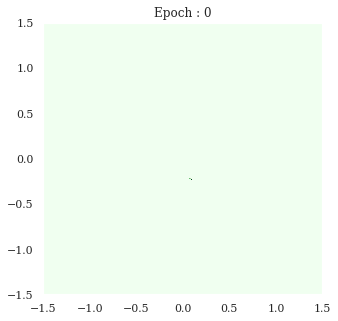

size of z torch.Size([100])
size of z.reshape() torch.Size([100, 1])
size of x_generated torch.Size([100, 2])


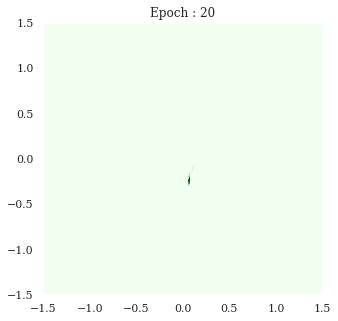

size of z torch.Size([100])
size of z.reshape() torch.Size([100, 1])
size of x_generated torch.Size([100, 2])


ValueError: Contour levels must be increasing

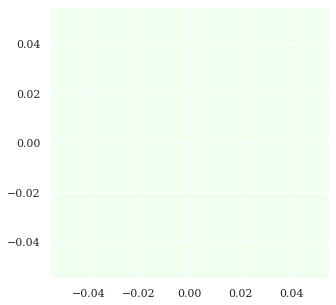

In [117]:
"""
Step 4 : Train models
""" 

import math

for epoch in range(num_epochs) : 
    for batch_idx, x in enumerate(loader) :
        optimizer.zero_grad()
        mu, log_sigma = enc(x)
        sigma = torch.exp(log_sigma)
        # print("size of mu, sigma", mu.size(), sigma.size())
        z = torch.normal(mu, sigma).reshape(-1, 1)
        # print("size of z", z.size())
        x_generated = dec(z) + 1/math.sqrt(150) * torch.randn_like(z)
        mse = nn.MSELoss()
        VLB = - reg_coeff * mse(x, x_generated) - 0.5 * (mu**2 + sigma**2 - 2*log_sigma)
        loss = -torch.mean(VLB)
        loss.backward()
        optimizer.step()
    
    # Visualize the intermediate result
    if epoch % (num_epochs // 100) == 0:
        z = torch.randn(size=(100,)).double()
        x_generated = dec(z.reshape(-1, 1))
        print("size of z", z.size())
        print("size of z.reshape()", z.reshape(-1, 1).size())
        print("size of x_generated", x_generated.size())
        x_generated = x_generated.detach().numpy()
        show_data(x_generated, f"Epoch : {epoch}")
        
